* 개선을 위한 방법
1. 마지막엔 test을 나누지말고 그냥 전부 train 시켜버린다
2. 쓸데 없는 열을 버려본다?
3. 앙상블 모델을 써볼까?

In [2]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [1]:
import pandas as pd
import numpy as np
import joblib
import math
import tensorflow as tf
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# 기존
import pandas as pd
import numpy as np
import joblib
import math
from keras.models import load_model

import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기 및 파악

In [ ]:
# 데스크탑
df = pd.read_csv("C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_train.csv", index_col=0)

# 노트북
# df = pd.read_csv("C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_train.csv", index_col=0)

In [ ]:
# 열 이름의 . 앞에 단어 제거
df.columns = [col.split('.')[-1] if '.' in col else col for col in df.columns]

In [ ]:
# # 시간
# df['year'].value_counts() # 년도
# df['month'].value_counts() # 월
# df['day'].value_counts() # 일
# df['time'].value_counts() # 시간(0~23)
# df['minute'].value_counts() # 분(10분 단위)
# df['stn_id'].value_counts() # 지점 번호

# -99 있음
# df['ws10_deg'].value_counts() # 10분 평균 풍향, 단위 : deg
# df['ws10_ms'].value_counts() # 10분 평균 풍속, 단위 : m/s
# df['ta'].value_counts() # 1분 평균 기온 10분 주기, 단위 : C
# df['re'].value_counts() # 강수 유무(0:무강수, 1:강수)
# df['hm'].value_counts() # 1분 평균 상대 습도 10분 주기, 단위 : %
# df['sun10'].value_counts() # 1분 일사량 10분 단위 합계, 단위 : MJ
# df['ts'].value_counts() # 1분 평균 지면온도 10분 주기, 단위 : C
# df['vis1'].value_counts() # 1분 평균 시정 10분 주기, 단위 : C(test데이터 셋엔 없음)
# df['class'].value_counts() # 시정 구간

# 파생변수

# 2. 문자열 데이터 정리

## 2-1. year열 I,J,K 순으로 0,1,2로 맵핑

In [ ]:
# year열 I,J,K 순으로 0,1,2로 맵핑
df['year'].value_counts()
df['year'] = df['year'].map({'I': 0, 'J': 1, 'K': 2})

## 2-2. 20개 지점을 5개의 지역으로 수치화

In [ ]:
# region는 stn_id에서 앞글자만 가져오고 숫자화
df['region'] = df['stn_id'].str[0]
# 알파벳 순서에 따라 번호를 부여
alphabet_order = {char: idx for idx, char in enumerate(sorted(df['region'].unique()))}
df['region'] = df['region'].map(alphabet_order)

# stn_id를 숫자화
# 원하는 순서대로 레이블을 숫자로 매핑하는 딕셔너리 생성
stn_id_mapping = {v: k for k, v in enumerate(['AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 
                                              'BA', 'BB', 'BC', 'BD', 'CA', 'CB', 'DA', 'DB', 
                                              'DC', 'EA', 'EB', 'EC'])}
# stn_id 열에 대해 딕셔너리를 적용하여 숫자로 변환
df['stn_id'] = df['stn_id'].map(stn_id_mapping)

In [ ]:
df_B = df[df['region'] == 1].reset_index(drop=True)

In [ ]:
df= df_B.copy()

# 3. 독립변수 결측치 처리

In [ ]:
df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,region
0,0,1,1,0,10,8,270.4,1.9,-7.5,0.0,59.3,0.0,-99.9,18800,4,1
1,0,1,1,0,20,8,263.0,2.3,-7.5,0.0,59.1,0.0,-99.9,18700,4,1
2,0,1,1,0,30,8,262.2,2.8,-7.5,0.0,58.7,0.0,-99.9,19916,4,1
3,0,1,1,0,40,8,274.3,3.0,-7.5,0.0,57.6,0.0,-99.9,20816,4,1
4,0,1,1,0,50,8,274.6,3.2,-7.6,0.0,57.8,0.0,-99.9,20283,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631287,2,12,31,23,10,11,269.9,7.2,-4.5,0.0,66.0,0.0,-99.9,15830,4,1
631288,2,12,31,23,20,11,266.2,7.6,-4.5,0.0,66.4,0.0,-99.9,15632,4,1
631289,2,12,31,23,30,11,271.1,7.5,-4.5,0.0,66.7,0.0,-99.9,15388,4,1
631290,2,12,31,23,40,11,268.9,7.0,-4.5,0.0,66.5,0.0,-99.9,15376,4,1


In [ ]:
# 수정(ta-ts계산)

# 변환할 열 리스트
na_cols = ['ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts']

# -99.9 값을 NaN으로 변환
df[na_cols] = df[na_cols].replace(-99.9, np.nan)
'''
# ts와 ta의 차이의 평균 계산
average_difference = (df['ta'] - df['ts']).mean()

# ts와 ta 중 하나라도 값이 있는 경우 평균 차이를 이용하여 채우기
df['ts'] = np.where(pd.isna(df['ts']) & pd.notna(df['ta']), df['ta'] - average_difference, df['ts'])
df['ta'] = np.where(pd.isna(df['ta']) & pd.notna(df['ts']), df['ts'] + average_difference, df['ta'])
'''
numeric_cols = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts']
# 선형보간법을 이용하여 NA값 처리
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')
df[numeric_cols] = df[numeric_cols].interpolate(method='bfill') # 그럼에도 na가 남아있으면


# 강수 유무에 대해선 전의 값으로 채움
df['re'] = df['re'].interpolate(method='ffill')

print(df.isnull().sum())

year        0
month       0
day         0
time        0
minute      0
stn_id      0
ws10_deg    0
ws10_ms     0
ta          0
re          0
hm          0
sun10       0
ts          0
vis1        0
class       0
region      0
dtype: int64


# 4. 이상치 처리

In [ ]:
# 인덱스 안쓰는 방식으로 수정
features = df.columns.difference(['year', 'month', 'day', 'time','minute', 'stn_id', 're', 'vis1', 'class','region'])

# 이상치 탐지 함수
def detect_outliers(df, features):
    for feature in features:
        data = df[feature]
        mean = data.mean()
        std = data.std()
        ucl = mean + 3 * std
        lcl = mean - 3 * std
        outliers = (data > ucl) | (data < lcl)
        df.loc[outliers, feature] = np.nan
        df[feature] = df[feature].interpolate(method='linear')  # 선형보간법
        # method='ffill', 'bfill'쓰면 직전 값, 직후 값으로 대체 가능
        # .interpolate(method='polynomial', order=2) # 2차 다항식 보간법
        # .interpolate(method='linear') # 선형보간법
    return df

df = detect_outliers(df,features)

# 6. class 결측치 채우기

**파생변수**

In [ ]:
# 모델 돌리기 위해 계절별 MINMAX를 해야함
# 그럴라면 파생변수 season이 필요

# 계절(봄 : 0, 여름 : 1, 가을 : 2, 겨울 : 3)
# 계절을 매핑하는 함수
def map_season(month):
    if month in [3, 4, 5]:
        return 0  # 봄
    elif month in [6, 7, 8]:
        return 1  # 여름
    elif month in [9, 10, 11]:
        return 2  # 가을
    else:
        return 3  # 겨울

df['season'] = df['month'].apply(map_season)


## 6-1. xgr를 활용하여 vis1 결측값 예측한 후, 해당 예측값을 결측값을 대체

In [ ]:
df

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,region,season
0,0,1,1,0,10,8,270.4,1.9,-7.5,0.0,59.3,0.0,-4.8,18800,4,1,3
1,0,1,1,0,20,8,263.0,2.3,-7.5,0.0,59.1,0.0,-4.8,18700,4,1,3
2,0,1,1,0,30,8,262.2,2.8,-7.5,0.0,58.7,0.0,-4.8,19916,4,1,3
3,0,1,1,0,40,8,274.3,3.0,-7.5,0.0,57.6,0.0,-4.8,20816,4,1,3
4,0,1,1,0,50,8,274.6,3.2,-7.6,0.0,57.8,0.0,-4.8,20283,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631287,2,12,31,23,10,11,269.9,7.2,-4.5,0.0,66.0,0.0,-4.9,15830,4,1,3
631288,2,12,31,23,20,11,266.2,7.6,-4.5,0.0,66.4,0.0,-4.9,15632,4,1,3
631289,2,12,31,23,30,11,271.1,7.5,-4.5,0.0,66.7,0.0,-4.9,15388,4,1,3
631290,2,12,31,23,40,11,268.9,7.0,-4.5,0.0,66.5,0.0,-4.9,15376,4,1,3


In [ ]:
# df_xgr 데이터프레임을 복사하여 사용합니다. 'class'는 초기에 'XGR'로 채워져 있다고 가정합니다.
df_xgr = df.copy()

# 클래스 분포를 확인하는 함수를 정의합니다.
def count_classes(df):
    return df['class'].value_counts()

In [ ]:
# 초기 클래스 분포를 저장합니다.
initial_class_counts = count_classes(df_xgr)

# 'vis1'이 결측치가 아닌 행과 결측치인 행을 구분합니다.
train_data = df_xgr[df_xgr['vis1'] != -99]
test_data = df_xgr[df_xgr['vis1'] == -99]

# 'vis1'과 'class'를 제외한 열을 feature로 선택합니다.
features = df_xgr.columns.difference(['vis1', 'class'])

# train 데이터의 feature와 target을 분리합니다.
X_train = train_data[features]
y_train = train_data['vis1']

# test 데이터의 feature를 선택합니다.
X_test = test_data[features]

In [ ]:
# 실제 수치형 데이터만 포함하는 리스트를 생성합니다.
numeric_features = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts']
# 계절을 반영한 MINMAX 스케일러 객체를 생성합니다.
minmax_scaler = MinMaxScaler()

# train 데이터를 기반으로 스케일러를 학습하고, train과 test 데이터 모두에 스케일링을 적용합니다.
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# 'season' 열을 기반으로 각 계절에 따라 스케일링을 적용합니다.
for season_value in range(4):  # 계절은 0부터 3까지의 값이 있습니다.
    train_mask = X_train_scaled['season'] == season_value
    test_mask = X_test_scaled['season'] == season_value
    if train_mask.sum() > 0:
        X_train_scaled.loc[train_mask, numeric_features] = minmax_scaler.fit_transform(X_train_scaled.loc[train_mask, numeric_features])
    if test_mask.sum() > 0:
        X_test_scaled.loc[test_mask, numeric_features] = minmax_scaler.transform(X_test_scaled.loc[test_mask, numeric_features])

In [ ]:
# XGBoost 회귀 모델을 학습하고 예측합니다.
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=123)
xgb_model.fit(X_train_scaled, y_train)
y_pred = xgb_model.predict(X_test_scaled)

# 예측된 값으로 test 데이터의 'vis1'의 결측치를 대체합니다.
test_data.loc[test_data['vis1'] == -99, 'vis1'] = y_pred[test_data['vis1'] == -99]

# 'vis1' 값을 기반으로 'class'를 분류하는 함수를 정의합니다.
def classify_visibility(vis1):
    if vis1 < 200:
        return 1
    elif vis1 < 500:
        return 2
    elif vis1 < 1000:
        return 3
    else:
        return 4

# test 데이터에 대해 'class' 값을 예측합니다.
test_data.loc[test_data['class'] == -99, 'class'] = test_data.loc[test_data['class'] == -99, 'vis1'].apply(classify_visibility)

C:\Users\Hong_PC\AppData\Local\Temp\ipykernel_21036\1451596185.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[test_data['vis1'] == -99, 'vis1'] = y_pred[test_data['vis1'] == -99]
C:\Users\Hong_PC\AppData\Local\Temp\ipykernel_21036\1451596185.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[test_data['class'] == -99, 'class'] = test_data.loc[test_data['class'] == -99, 'vis1'].apply(classify_visibility)


In [ ]:
# 전체 데이터프레임에 test 데이터의 변경 사항을 반영합니다.
df_xgr.update(test_data)

# 예측된 'vis1' 값을 기반으로 한 최종 'class' 분포를 계산합니다.
final_class_counts = count_classes(df_xgr)

# 초기 클래스 분포와 최종 클래스 분포를 계산하여 출력합니다.
print("초기 클래스 분포:\n", initial_class_counts)
print("최종 클래스 분포:\n", final_class_counts)

# 예측된 클래스 분포를 시각화합니다.
df_pred_class = pd.DataFrame({'y_pred': y_pred})
df_pred_class['pred_class'] = df_pred_class['y_pred'].apply(classify_visibility)

초기 클래스 분포:
  4     613841
 2       6538
 3       4393
-99      3281
 1       3239
Name: class, dtype: int64
최종 클래스 분포:
 4.0    617117
2.0      6538
3.0      4394
1.0      3243
Name: class, dtype: int64


C:\Users\Hong_PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Hong_PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Hong_PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Hong_PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Hong_PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47000 (\N{HANGUL SYLLABL

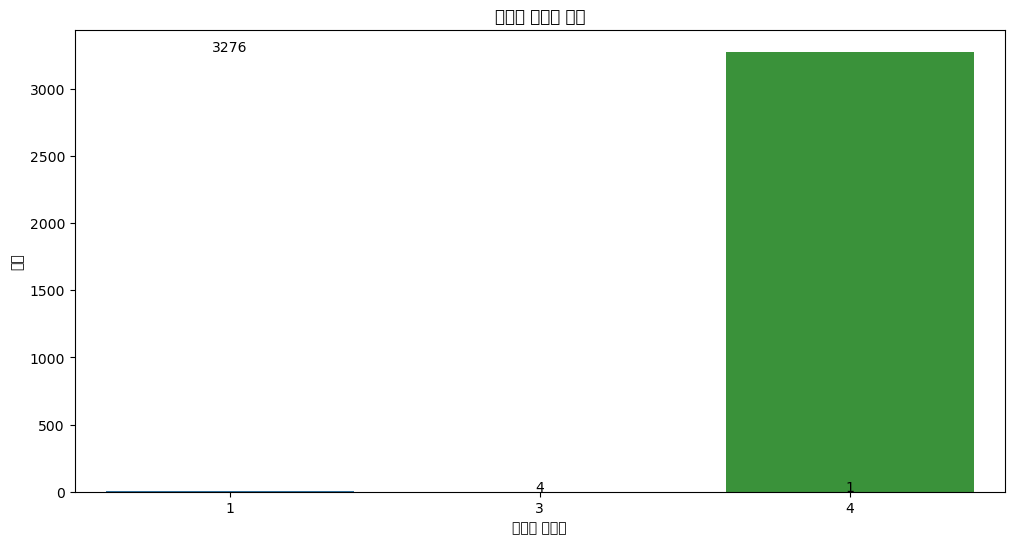

In [ ]:
# 예측된 클래스 분포를 막대 그래프로 나타냅니다.
plt.figure(figsize=(12, 6))
sns.barplot(x=df_pred_class['pred_class'].value_counts().index, y=df_pred_class['pred_class'].value_counts().values)
plt.title('예측된 클래스 분포')
plt.xlabel('예측된 클래스')
plt.ylabel('개수')

# 막대 위에 숫자를 표시합니다.
for index, value in enumerate(df_pred_class['pred_class'].value_counts().values):
    plt.text(index, value + 0.05, str(value), ha='center')

plt.show()

In [ ]:
# vis1 2000이상인 값은 2000으로 변경
df_xgr.loc[df_xgr['vis1'] >= 20000.0, 'vis1'] = 20000.0
df_xgr.loc[df_xgr['vis1'] <= 0.0, 'vis1'] = 0.0

## 6-2. 완성된 데이터 셋 저장

In [ ]:
# xgr

# 노트북
# joblib.dump(df_xgr, 'C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\df_xgr.pkl')

# 데스크탑
# joblib.dump(df_xgr, "C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\df_xgr.pkl")

# 7. 파생변수

In [ ]:
# 계절(봄 : 0, 여름 : 1, 가을 : 2, 겨울 : 3)
# 계절을 매핑하는 함수
def map_season(month):
    if month in [3, 4, 5]:
        return 0  # 봄
    elif month in [6, 7, 8]:
        return 1  # 여름
    elif month in [9, 10, 11]:
        return 2  # 가을
    else:
        return 3  # 겨울

df['season'] = df['month'].apply(map_season)

In [ ]:
# 이슬점(dew_point)
# 이슬점 계산 함수
def calculate_dew_point(temp_celsius, relative_humidity):
    a = 17.27
    b = 237.7
    # 상대 습도가 0이면 매우 낮은 값을 설정하여 log(0)가 발생하지 않도록 한다.
    rh = max(relative_humidity / 100.0, 1e-6)
    alpha = ((a * temp_celsius) / (b + temp_celsius)) + math.log(rh)
    dew_point = (b * alpha) / (a - alpha)
    return dew_point

# 이슬점 계산하여 새로운 열 추가
df['dew_point'] = df.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)

In [ ]:
# 풍향
# 풍향을 16방위로 변환하는 함수
def convert_wind_direction(wind_dir):
    # 22.5도 간격으로 16방위로 매핑
    direction = int((wind_dir + 11.25) % 360 / 22.5)
    return direction

# 풍향을 16방위로 변환하여 새로운 열에 추가
df['ws10_deg_16'] = df['ws10_deg'].apply(convert_wind_direction)


In [ ]:
# 일교차(diurnal_range)
# 날짜(year, month, day), 관측 장소(stn_id)로 그룹화하여 일교차 계산
df['diurnal_range'] = df.groupby(['year', 'month', 'day', 'stn_id'])['ts'].transform(lambda x: x.max() - x.min())

In [ ]:
# 기온-이슬점(안개형성조건, 기온이 이슬점 이하일 때 잘 발생)
df['ts_dew_diff'] = df['ts'] - df['dew_point']

In [ ]:
# 50분 이동평균(습도)
def calculate_rolling_mean(group):
    group['5_hm'] = group['hm'].rolling(window=5).mean()
    group['5_hm'] = group['5_hm'].fillna(group['hm'])
    return group

# 각 stn_id별로 그룹화하여 함수 적용
df = df.groupby('stn_id', group_keys=False).apply(calculate_rolling_mean)

In [ ]:
# 필요 없는 열 제거(시간 디테일 지역이라던가)

In [ ]:
df_train = df.copy()

# fog_test.csv전처리

In [ ]:
# 데스크탑
df_test = pd.read_csv("C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_test.csv", index_col=0)
df_original = pd.read_csv("C:\\Users\\Hong_PC\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_test.csv", index_col=0)
# 노트북
# f_test = pd.read_csv("C:\\Users\\User\\Desktop\\기상청 날씨 빅데이터 공모전\\과제2\\fog_test.csv", index_col=0)

In [ ]:
df = df_test.copy()

**기본 전처리**

In [ ]:
# 열 이름의 . 앞에 단어 제거
df.columns = [col.split('.')[-1] if '.' in col else col for col in df.columns]

# year열 I, J, K 순으로 0, 1, 2로 맵핑 (현재 L만 있어서 0으로 맵핑)
df['year'] = df['year'].map({'L': 0})

# region는 stn_id에서 앞글자만 가져오고 숫자화
df['region'] = df['stn_id'].str[0]
alphabet_order = {char: idx for idx, char in enumerate(sorted(df['region'].unique()))}
df['region'] = df['region'].map(alphabet_order)

# stn_id를 숫자화
stn_id_mapping = {v: k for k, v in enumerate(['AI', 'BE', 'CC', 'DD'])}
df['stn_id'] = df['stn_id'].map(stn_id_mapping)

# 마지막 행이 결측열이길래 제거
df.loc[:, df.columns != 'class'] = df.loc[:, df.columns != 'class'].fillna(method='ffill')



In [ ]:
#B지역만
df_test_B = df[df['region'] == 1]

In [ ]:
df= df_test_B.copy()

**결측치 제거**

In [ ]:
# df에서 변수들 -99 NA처리
# 변환할 열 리스트
na_cols = ['ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts']

# -99.9 값을 NaN으로 변환
df[na_cols] = df[na_cols].replace(-99.9, np.nan)
'''
# ts와 ta의 차이의 평균 계산
average_difference = (df['ta'] - df['ts']).mean()

# ts와 ta 중 하나라도 값이 있는 경우 평균 차이를 이용하여 채우기
df['ts'] = np.where(pd.isna(df['ts']) & pd.notna(df['ta']), df['ta'] - average_difference, df['ts'])
df['ta'] = np.where(pd.isna(df['ta']) & pd.notna(df['ts']), df['ts'] + average_difference, df['ta'])
'''
numeric_cols = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts']
# 선형보간법을 이용하여 NA값 처리
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')
df[numeric_cols] = df[numeric_cols].interpolate(method='bfill') # 그럼에도 na가 남아있으면


# 강수 유무에 대해선 전의 값으로 채움
df['re'] = df['re'].interpolate(method='ffill')

print(df.isnull().sum())

year            0
month           0
day             0
time            0
minute          0
stn_id          0
ws10_deg        0
ws10_ms         0
ta              0
re              0
hm              0
sun10           0
ts              0
class       52081
region          0
dtype: int64


In [ ]:
# class 결측치 제거
df['class'] = df['class'].replace(-99.0, np.nan)

**이상치 제거**

In [ ]:
features = df.columns.difference(['year', 'month', 'day', 'time','minute', 'stn_id', 're', 'vis1', 'class','region'])

# 이상치 탐지 함수
def detect_outliers(df, features):
    for feature in features:
        data = df[feature]
        mean = data.mean()
        std = data.std()
        ucl = mean + 3 * std
        lcl = mean - 3 * std
        outliers = (data > ucl) | (data < lcl)
        df.loc[outliers, feature] = np.nan
        df[feature] = df[feature].interpolate(method='linear')  # 선형보간법
        # method='ffill', 'bfill'쓰면 직전 값, 직후 값으로 대체 가능
        # .interpolate(method='polynomial', order=2) # 2차 다항식 보간법
        # .interpolate(method='linear') # 선형보간법
    return df

df = detect_outliers(df,features)

**파생 변수**

In [ ]:
# 계절 매핑
def map_season(month):
    if month in [3, 4, 5]:
        return 0  # 봄
    elif month in [6, 7, 8]:
        return 1  # 여름
    elif month in [9, 10, 11]:
        return 2  # 가을
    else:
        return 3  # 겨울
df['season'] = df['month'].apply(map_season)

# 이슬점 계산 함수
def calculate_dew_point(temp_celsius, relative_humidity):
    a = 17.27
    b = 237.7
    rh = max(relative_humidity / 100.0, 1e-6)
    alpha = ((a * temp_celsius) / (b + temp_celsius)) + np.log(rh)
    dew_point = (b * alpha) / (a - alpha)
    return dew_point
df['dew_point'] = df.apply(lambda row: calculate_dew_point(row['ta'], row['hm']), axis=1)

# 풍향을 16방위로 변환
def convert_wind_direction(wind_dir):
    direction = int((wind_dir + 11.25) % 360 / 22.5)
    return direction
df['ws10_deg_16'] = df['ws10_deg'].apply(convert_wind_direction)

# 날짜(year, month, day), 관측 장소(stn_id)로 그룹화하여 일교차 계산
df['diurnal_range'] = df.groupby(['year', 'month', 'day', 'stn_id'])['ts'].transform(lambda x: x.max() - x.min())

# 기온-이슬점
df['ts_dew_diff'] = df['ts'] - df['dew_point']

# 50분 이동평균(습도)
def calculate_rolling_mean(group):
    group['5_hm'] = group['hm'].rolling(window=5).mean()
    group['5_hm'] = group['5_hm'].fillna(group['hm'])
    return group
df = df.groupby('stn_id', group_keys=False).apply(calculate_rolling_mean)

In [ ]:
df_test = df.copy()

# 정규화

In [ ]:
numeric_features = ['ws10_deg', 'ws10_ms', 'ta', 'hm', 'sun10', 'ts','dew_point', 'diurnal_range', '5_hm']

In [ ]:
# 훈련 데이터에 스케일링 적용
scaled_train_data = df_train.copy()
scaled_test_data = df_test.copy()

In [ ]:
for season_value in range(4):  # 계절은 0부터 3까지의 값이 있습니다.
    scaler = MinMaxScaler()

    # 훈련 데이터에 대해 스케일러 학습 및 변환
    train_mask = scaled_train_data['season'] == season_value
    if train_mask.sum() > 0:
        scaled_train_data.loc[train_mask, numeric_features] = scaler.fit_transform(scaled_train_data.loc[train_mask, numeric_features])

        # 테스트 데이터에 대해 스케일러 변환만 적용
        test_mask = scaled_test_data['season'] == season_value
        if test_mask.sum() > 0:
            scaled_test_data.loc[test_mask, numeric_features] = scaler.transform(scaled_test_data.loc[test_mask, numeric_features])


## 8-1. Bi-directional LSTM 모델링

**모델 학습**

In [ ]:
df_train

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,...,ts,vis1,class,region,season,dew_point,ws10_deg_16,diurnal_range,ts_dew_diff,5_hm
0,0,1,1,0,10,8,270.4,1.9,-7.5,0.0,...,-4.8,18800,4,1,3,-14.053639,12,9.8,9.253639,59.30
1,0,1,1,0,20,8,263.0,2.3,-7.5,0.0,...,-4.8,18700,4,1,3,-14.094795,12,9.8,9.294795,59.10
2,0,1,1,0,30,8,262.2,2.8,-7.5,0.0,...,-4.8,19916,4,1,3,-14.177480,12,9.8,9.377480,58.70
3,0,1,1,0,40,8,274.3,3.0,-7.5,0.0,...,-4.8,20816,4,1,3,-14.407481,12,9.8,9.607481,57.60
4,0,1,1,0,50,8,274.6,3.2,-7.6,0.0,...,-4.8,20283,4,1,3,-14.459499,12,9.8,9.659499,58.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631287,2,12,31,23,10,11,269.9,7.2,-4.5,0.0,...,-4.9,15830,4,1,3,-9.877626,12,5.5,4.977626,66.36
631288,2,12,31,23,20,11,266.2,7.6,-4.5,0.0,...,-4.9,15632,4,1,3,-9.801203,12,5.5,4.901203,66.20
631289,2,12,31,23,30,11,271.1,7.5,-4.5,0.0,...,-4.9,15388,4,1,3,-9.744155,12,5.5,4.844155,66.12
631290,2,12,31,23,40,11,268.9,7.0,-4.5,0.0,...,-4.9,15376,4,1,3,-9.782162,12,5.5,4.882162,66.20


In [ ]:
df_test

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,...,sun10,ts,class,region,season,dew_point,ws10_deg_16,diurnal_range,ts_dew_diff,5_hm
52561,0,1,1,0,0,1,296.1,3.4,-1.7,0.0,...,0.0,-4.7,NaN,1,3,-8.822293,13,13.2,4.122293,58.20
52562,0,1,1,0,10,1,288.2,2.4,-2.0,0.0,...,0.0,-4.7,NaN,1,3,-8.631177,13,13.2,3.931177,60.40
52563,0,1,1,0,20,1,293.2,2.6,-2.0,0.0,...,0.0,-4.7,NaN,1,3,-8.780085,13,13.2,4.080085,59.70
52564,0,1,1,0,30,1,293.6,1.9,-2.5,0.0,...,0.0,-4.7,NaN,1,3,-8.977567,13,13.2,4.277567,61.00
52565,0,1,1,0,40,1,292.2,2.5,-2.4,0.0,...,0.0,-4.7,NaN,1,3,-8.716698,13,13.2,4.016698,60.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105116,0,12,31,23,10,1,304.6,1.4,-0.4,0.0,...,0.0,-0.7,NaN,1,3,-1.435271,14,13.5,0.735271,91.16
105117,0,12,31,23,20,1,333.1,1.7,-0.2,0.0,...,0.0,-0.9,NaN,1,3,-1.076227,15,13.5,0.176227,92.06
105118,0,12,31,23,30,1,319.3,1.2,-0.2,0.0,...,0.0,-0.8,NaN,1,3,-1.076227,14,13.5,0.276227,92.80
105119,0,12,31,23,40,1,287.9,0.8,-0.2,0.0,...,0.0,-0.8,NaN,1,3,-1.076227,13,13.5,0.276227,93.22


count    631292.000000
mean          3.421616
std           7.409321
min         -99.000000
25%           4.000000
50%           4.000000
75%           4.000000
max           4.000000
Name: class, dtype: float64
[  4 -99   3   2   1]
Sequences shape: (628005, 6, 20)
Targets shape: (628005,)
Targets min value: 1.0
Targets max value: 4.0
Sequences shape: (52554, 6, 19)
Targets shape: (52554,)
Targets min value: 8.0
Targets max value: 99.9
y_train before to_categorical: [4. 4. 4. ... 4. 4. 4.]
y_train min value: 1.0
y_train max value: 4.0
Class Weights: {0: 290.835597406607, 1: 120.06940195778526, 2: 142.95720464375142, 3: 0.2557710384285181}
Epoch 1/20
13738/13738 [==============================] - 137s 9ms/step - loss: 4.8063 - accuracy: 0.5140 - val_loss: 1.1833 - val_accuracy: 0.6727
Epoch 2/20
13738/13738 [==============================] - 206s 15ms/step - loss: 4.6670 - accuracy: 0.5379 - val_loss: 1.5780 - val_accuracy: 0.5035
Epoch 3/20
13738/13738 [==============================]

<AxesSubplot:>

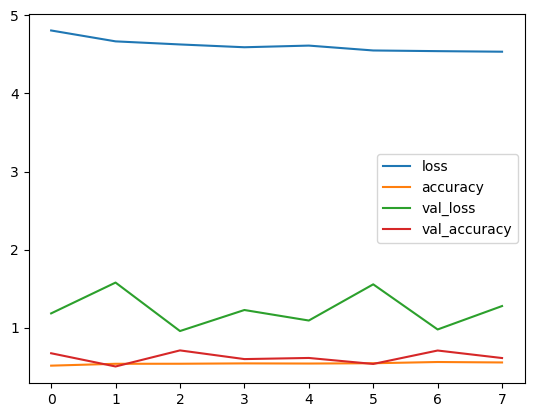

In [ ]:
# 'class' 열의 값 점검
print(df_train['class'].describe())
print(df_train['class'].unique())

# 이상값이 있는 경우 제거 또는 수정
# 예: 'class' 열의 값이 1에서 4 사이인 경우만 사용
df_train = df_train[df_train['class'].between(1, 4)]

# 필요한 열만 선택 (수정된 train_data)
columns = ['year', 'month', 'day', 'time', 'minute', 'stn_id', 'ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts', 'region', 'season', 'dew_point', 'ws10_deg_16', 'diurnal_range', 'ts_dew_diff', '5_hm']
train_data = df_train[columns + ['class']].values
test_data = df_test[columns].values

# 시퀀스 생성
sequence_length = 6
X_train, y_train = create_sequences(train_data, sequence_length, -1)
X_test, _ = create_sequences(test_data, sequence_length, -1)

# y_train 값 확인
print("y_train before to_categorical:", y_train)
print("y_train min value:", y_train.min())
print("y_train max value:", y_train.max())

y_train = to_categorical(y_train - 1)

# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=[1, 2, 3, 4], y=df_train['class'])
class_weight_dict = {i-1: weight for i, weight in enumerate(class_weights, start=1)}

# 클래스 1과 2의 가중치 더 높여주기
class_weight_dict[0] *= 6
class_weight_dict[1] *= 5
class_weight_dict[2] *= 4

print("Class Weights:", class_weight_dict)

# Bi-directional LSTM 모델 정의
model = Sequential()
model.add(Bidirectional(LSTM(32, activation='tanh', return_sequences=True), input_shape=(sequence_length, len(columns))))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(16, activation='tanh')))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, batch_size=32, epochs=20, 
                    validation_split=0.3, 
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping])

# 학습 결과 시각화
pd.DataFrame.from_dict(history.history).plot()

In [ ]:
# # CSI 계산 예시 (필요에 따라 추가적으로 수행)
# def calculate_csi(y_true, y_pred):
#     confusion = confusion_matrix(y_true, y_pred)
#     csi_values = []
#     for i in range(1, 5):  # class 1 to 4
#         tp = np.sum((y_true == i) & (y_pred == i))
#         fp = np.sum((y_true != i) & (y_pred == i))
#         fn = np.sum((y_true == i) & (y_pred != i))
#         csi = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
#         csi_values.append(csi)
#     return np.mean(csi_values)

# csi = calculate_csi(y_test_class, y_pred_class)
# print(f'CSI: {csi}')

In [ ]:
# 시퀀스 생성 함수 정의
def create_sequences_for_test(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# df_test에 시퀀스 생성
X_test_sequences = create_sequences_for_test(test_data, sequence_length)

# 예측 수행
predictions = model.predict(X_test_sequences)

# 예측된 클래스 찾기 (softmax로 인해 확률 분포로 나옴)
predicted_classes = np.argmax(predictions, axis=1) + 1

df_test['class'] = np.nan
df_test.iloc[sequence_length-1:, df_test.columns.get_loc('class')] = predicted_classes

# 예측 결과 확인
df_test['class'].value_counts()

NameError: name 'test_data' is not defined

In [2]:
# 처음 몇 개의 값이 없어서 NaN인 부분을 class 4로 채우기
df_test['class'].fillna(4, inplace=True)
# 예측된 class 값만 df_original에 반영
df_original.loc[df_original['fog_test.stn_id'].str[0] == 'B', 'fog_test.class'] = df_test['class'].values #이렇게 넣어버리면 뒤 값이 날라감
df_original['class'].fillna(4, inplace=True)
df_original.to_csv('240371.csv', index=False)

NameError: name 'df_test' is not defined